# Dog breed identification competition

In [2]:
main_dir = '/home/paperspace/Dog_breed_identification'

In [3]:
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import pandas as pd
import pre_processing as pp

In [4]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
os.chdir(main_dir)

In [6]:
train_labels = pd.read_csv('labels.csv')
train_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Create validation set
##### make sure to use stratefied sampling

In [7]:
# %mkdir valid
# num_breed = train_labels['breed'].value_counts()
# breed_probs = num_breed/train_labels.shape[0]
# train_labels['sample_prob'] = 0
# train_labels
# for x in breed_probs.index:
#     indv_prob = breed_probs[x]/num_breed[x]
#     train_labels.loc[train_labels['breed'] == x, 'sample_prob'] = indv_prob

# valid_set_fns = np.random.choice(train_labels['id'], int(len(train_labels['id'])*.3),
#                                    replace = False, p = train_labels['sample_prob'])

# [os.rename(main_dir+'/train/'+x+'.jpg', main_dir+'/valid/'+x+'.jpg')
#  for x in valid_set_fns];


### Organize data into group folders for both validation and training sets

In [8]:
# os.chdir(main_dir+'/valid')
# moved_valid_files = glob('*jpg')
# moved_valid_files = pd.DataFrame(moved_valid_files, columns = ['id']).applymap(lambda y: y[:-4])
# valid_labels = moved_valid_files.merge(train_labels)
# os.chdir(main_dir + '/valid')
# [pp.organize_groups(valid_labels, breed) for breed in valid_labels['breed'].unique()];

# os.chdir(main_dir + '/train')
# rem_training_files = pd.DataFrame(glob('*.jpg'), columns = ['id']).applymap(lambda x: x[:-4])
# rem_training_labels = rem_training_files.merge(train_labels, how = 'inner', on = 'id')
# [pp.organize_groups(rem_training_labels, breed) for breed in rem_training_labels['breed'].unique()];

In [9]:
os.chdir(main_dir + '/train')
file_tree = os.walk(".")
num_per_group_train = pd.DataFrame([(x[0][2:],len(x[2])) for x in file_tree], columns = ['breed', 'freq']).loc[1:,:]

os.chdir(main_dir + '/valid')
file_tree = os.walk(".")
num_per_group_valid = pd.DataFrame([(x[0][2:],len(x[2])) for x in file_tree], columns = ['breed', 'freq']).loc[1:,:]

In [10]:
num_per_group_valid.sort_values(by = ['freq'], ascending=False, inplace = True)
num_per_group_train.sort_values(by = ['freq'], ascending=False, inplace = True)

In [11]:
plt.close('all')

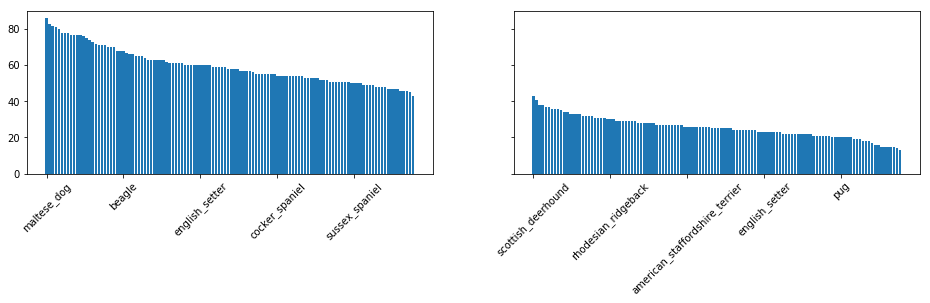

In [12]:
plt.close('all')
fig,(ax1,ax2)= plt.subplots(figsize=(16, 3), ncols = 2, sharey = True)
ax1.bar(np.arange(0,len(num_per_group_train['freq']),1), num_per_group_train['freq'])
xlabels_pos = range(0,len(num_per_group_train['breed']),25)
xlabels = num_per_group_train['breed'].iloc[xlabels_pos].as_matrix()
ax1.set_xticks(xlabels_pos);
ax1.set_xticklabels(xlabels, rotation = 45);

ax2.bar(np.arange(0,len(num_per_group_valid['freq']),1), num_per_group_valid['freq'])
xlabels_pos = range(0,len(num_per_group_valid['breed']),25)
xlabels = num_per_group_valid['breed'].iloc[xlabels_pos].as_matrix()
ax2.set_xticks(xlabels_pos);
ax2.set_xticklabels(xlabels, rotation = 45);

### Train resnextx50 model and save weights

In [13]:
#define data-augmentation paramaters, 
PATH = "/home/paperspace/data/dogscats/"
sz = 224
arch=resnext50
bs=24

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
    return data

data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 84/84 [00:10<00:00,  8.21it/s]


In [14]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 69%|██████▊   | 658/959 [00:11<00:05, 57.56it/s, loss=0.198] 

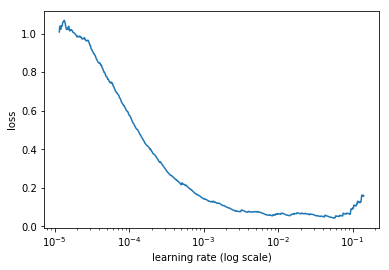

 69%|██████▊   | 658/959 [00:30<00:13, 21.91it/s, loss=0.198]

In [15]:
learn.sched.plot()

In [18]:
learn.fit(1e-3, 4)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.044335   0.01916    0.993552  
    1      0.06833    0.01876    0.994048                     
    2      0.056378   0.020119   0.993552                     
    3      0.041792   0.019662   0.993056                     



In [19]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [20]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.036679   0.017273   0.993552  
    1      0.03091    0.01702    0.993552                     
    2      0.031035   0.021335   0.992063                     



[0.021334698, 0.99206348969822833]

In [21]:
learn.save('244_pre_multiCyc')

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult = 2)

In [ ]:
learn.set_data(get_data(229, bs))

In [ ]:
learn.save('299_all_50')

In [ ]:
learn.load('299_all_50')

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy(probs,y)